# Deep Learning with *Dobble*

**Purpose**: A deep learning model that can play the card game *Dobble* (also known as *Spot it!*)

**Context**: Graded hands-on project as part of the *Deep Learning* Seminar at [Justus Liebig University Giessen](https://www.uni-giessen.de)

**Authors**: 2023 Marvin Theiss, Nina Winkelmann

**License**: [GNU General Public License v3](https://www.gnu.org/licenses/gpl-3.0.html)

<br>

## Contents
- [Import packages](#packages)
- [Part 1: The card game *Dobble*](#dobble-game)
    * [1.1 Finite projective planes](#finite-projective-planes)
        + [1.1.1 On the existence of finite projective planes](#existence-of-finite-projective-planes)
- [Part 2: Creating a custom *Dobble* deck](#dobble-deck)
    * [2.1 Prime powers](#dobble-deck-prime-powers)
    * [2.2 Incidence matrices for finite projective planes](#dobble-deck-incidence-matrices)
    * [2.3 Coordinates and radii to place emojis](#dobble-deck-coordinates-and-radii)
    * [2.4 Create empty *Dobble* card](#dobble-deck-empty-card)
        + [2.4.1 Visualize circle packings](#dobble-deck-visualize-packings)
    * [2.5 Load emoji from directory](#dobble-deck-load-emoji)
    * [2.6 Place emoji on card](#dobble-deck-place-emoji)
    * [2.7 Create a single *Dobble* card](#dobble-deck-single-card)
    * [2.8 Read in names of all emojis of a given set](#dobble-deck-read-emoji-names)
    * [2.9 Create a full *Dobble* deck](#dobble-deck-full-decks)
    * [2.10 All possible combinations of cards in a *Dobble* deck](#dobble-deck-combinations)
- [Part 3: A deep neural network to play *Dobble*](#neural-network)
    * [3.1 *DobbleDeck*](#neural-network-dataset)
        + [3.1.1 Split the Dataset](#neural-network-split-dataset)
        + [3.1.2 Transforms](#neural-network-training-transforms)
        + [3.1.3 DataLoaders](#neural-network-dataloaders)
    * [3.2 *DobbleNet*](#neural-network-dobble-net)
    * [3.3 Training & testing routines](#neural-network-training-testing-routines)
        + [3.3.1 Loss function](#neural-network-loss)
    * [3.4 Utility functions](#neural-network-utility-functions)

<a id='packages'></a>

## Import packages
Before we start, we import all the packages that we'll be using later on.

In [4]:
import os
import random
import csv
from itertools import combinations
from math import log2

import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageDraw

import torch
import torch.nn as nn
import torchvision

<a id='dobble-game'></a>

## Part 1: The card game *Dobble*
<font color = red>**TO-DO:**</font> Expand this part!

Online articles explaining the mathematics of *Dobble*:
- [The maths behind Dobble](https://mickydore.medium.com/dobble-theory-and-implementation-ff21ddbb5318) by *Micky Dore*
- [Finite Projective Planes and the Math of Spot It!](https://puzzlewocky.com/games/the-math-of-spot-it/) on *puzzlewocky.com*
- [The Mathematics of Toys and Games](https://www.petercollingridge.co.uk/blog/mathematics-toys-and-games/dobble/) by *Peter Collingridge*
- [Dobble](https://en.wikipedia.org/wiki/Dobble) on *Wikipedia*

A diploma thesis (in German) focusing on the math behind *Dobble*:
- [Ein Einblick in die Mathematik hinter dem Kartenspiel Dobble](https://unipub.uni-graz.at/obvugrhs/download/pdf/6499156?originalFilename=true) by *Christian Kathrein*

In short, a deck of *Dobble* cards can be interpreted as a finite projective plane where the **cards** of the deck **correspond to lines** in the projective plane and the **symbols** on each card **correspond to points** in the projective plane. The order of the finite projective plane is one less than the number of symbols on each card.

<a id='finite-projective-planes'></a>

### 1.1 Finite projective planes
Some **key aspects** of projective planes to keep in mind:
- Each projective plane (finite or infinite) has as many lines as it has points.
- For every *finite* projective plane, there exists an integer $n \geq 2$ such that ...
    * the number of points and lines is given by $n^2 + n + 1$,
    * there are $n + 1$ points on each line,
    * there are $n + 1$ lines passing through each point.
- This number $n$ is called the **order** of the projective plane.

<a id='existence-of-finite-projective-planes'></a>

#### 1.1.1 On the existence of finite projective planes

It is known that there exists a projective plane of order $n = p^k$ for every *prime power* $p^k$. What's perhaps even more intriguing is the fact that, as of today, **all** known finite projective planes are of order $p^k$ for some prime number $p$.

<a id='dobble-deck'></a>

## Part 2: Creating a custom *Dobble* deck
Emojis are taken from [OpenMoji](https://openmoji.org) and are free to use under the [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/) license, which is compatible with the [GNU General Public License v3](https://www.gnu.org/licenses/gpl-3.0.en.html).

<a id='dobble-deck-prime-powers'></a>

### 2.1 Prime powers

In [5]:
def is_prime(num):
    """
    Check if a number is prime.

    Args:
        num (int): The number to be checked.

    Returns:
        bool: True if the number is prime, False otherwise.

    Examples:
        >>> is_prime(5)
        True

        >>> is_prime(10)
        False
    """
    if num % 1 != 0 or num <= 1:
        return False

    # Check for non-trivial factors
    for i in range(2, int(num ** 0.5) + 1):
        if num % i == 0:
            return False
    return True


def is_prime_power(num):
    """
    Check if a number is a prime power.

    Args:
        num (int): The number to be checked.

    Returns:
        bool: True if the number is a prime power, False otherwise.

    Examples:
        >>> is_prime_power(8)
        True

        >>> is_prime_power(15)
        False

        >>> is_prime_power(17)
        True
    """
    if num % 1 != 0 or num <= 1:
        return False

    # Compute the i-th root of num and check if it's prime
    for i in range(1, int(log2(num)) + 1):
        root = num ** (1 / i)
        if root % 1 == 0 and is_prime(root):
            return True
    return False


# Check out all prime powers up to n = 50
first_prime_powers = []
for i in range(50):
    if is_prime_power(i + 1):
        first_prime_powers.append(i + 1)
print(first_prime_powers)


[2, 3, 4, 5, 7, 8, 9, 11, 13, 16, 17, 19, 23, 25, 27, 29, 31, 32, 37, 41, 43, 47, 49]


<a id='dobble-deck-incidence-matrices'></a>

### 2.2 Incidence matrices for finite projective planes

The function `compute_incidence_matrix` is based on the algorithm presented in the article [The Dobble Algorithm](https://mickydore.medium.com/the-dobble-algorithm-b9c9018afc52) by *Micky Dore*.

In [6]:
def compute_incidence_matrix(order):
    """
    Compute the incidence matrix corresponding to a finite projective plane of the specified order.

    Args:
        order (int): The order of the finite projective plane.

    Returns:
        numpy.ndarray: The computed incidence matrix. The rows correspond to lines and the columns correspond to points.

    Raises:
        ValueError: If the argument 'order' is not a prime power.

    Example:
        >>> compute_incidence_matrix(2)
        array([[ True,  True,  True, False, False, False, False],
               [ True, False, False,  True,  True, False, False],
               [ True, False, False, False, False,  True,  True],
               [False,  True, False,  True, False,  True, False],
               [False,  True, False, False,  True, False,  True],
               [False, False,  True,  True, False, False,  True],
               [False, False,  True, False,  True,  True, False]])
    """
    if not is_prime_power(order):
        raise ValueError("The 'order' argument must be a prime power.")
    
    # Number of points/lines of a finite projective plane of order n is given by n^2 + n + 1
    size = order ** 2 + order + 1
    
    # Preallocate incidence matrix, where rows correspond to lines and columns correspond to points
    incidence_matrix = np.zeros((size, size), dtype=bool)

    # Determine which points are on the first line
    which_line = 0
    which_pts = list(range(order + 1))
    incidence_matrix[which_line, which_pts] = True

    # Determine which points are on the next n lines
    for line in range(order):
        which_line += 1
        # The first n + 1 lines will all share point '0'
        which_pts = [0]
        start = (line + 1) * order + 1
        end = start + order
        which_pts.extend(list(range(start, end)))
        incidence_matrix[which_line, which_pts] = True
    
    # Determine which points are on the final n^2 lines
    for block in range(order):
        for line in range(order):
            which_line += 1
            which_pts = [block + 1]
            for pt in range(order):
                which_pts.append(order * (pt + 1) + ((block * pt + line) % order) + 1)
            incidence_matrix[which_line, which_pts] = True
    
    return incidence_matrix


<a id='dobble-deck-coordinates-and-radii'></a>

### 2.3 Coordinates and radii to place emojis
We want to place a (varying) number of emojis on our *Dobble* cards. When doing so, we want to utilize the available space on each card as much as possible wihtout having the emojis overlap. The emojis we'll be using are square images of equal size (618 x 618 pixels) with transparent background (.png-files). Due to the [styleguide](https://openmoji.org/styleguide/#styleguide) that's used by [OpenMoji](https://openmoji.org), most emojis do not extend into the corners of the image. Thus, to utilize the available space on each *Dobble* card as much as possible such that no overlapping occurs, we can employ results from the branch of mathematics known as [circle packing](https://en.wikipedia.org/wiki/Circle_packing).

On his website [packomania.com](http://www.packomania.com), Prof. Dr.-Ing. [Eckehard Specht](https://www.ltv.ovgu.de/Mitarbeiter/Lehrstuhlinhaber/Prof_+Eckehard+Specht-p-210.html) provides an incredible amount of data on circle packings. From this website, we have already downloaded the data we need and placed it into the subdirectory `coords` of our current working directory. Inside this directory, there are the following five subdirectories:

- `cci`
- `ccib`
- `ccic`
- `ccir`
- `ccis`

The names of these subdirectories are obtained from the names that Prof. Dr.-Ing. Eckehard Specht uses for the different circle packings that he provides on his [website](http://www.packomania.com).

All of the subdirectories qualitatively contain the same data:

- Multiple text files containing the **coordinates of all the circles** in the circle packing. The file names consist of the name of the directory followed by the number of circles in the circle packing (e.g., *cci4.txt* or *ccir32.txt*). All text files consist of three columns: the first column stores a simple counter, the second column contains the $x$-coordinate, and the third column contains the $y$-coordinate of the center of each circle.
- A single text file `radius.txt` that stores the **radius of the largest circle** of each circle packing. This file contains two columns: the first one specifies the number of circles in the circle packing and the second one provides the radius of the largest circle in the packing. The radii of all the other circles can be computed based on this radius. We will get back to this later.

Generally, this data is available for circle packings where the number of circles are integers up to $n = 50$ that can be expressed as $p^k + 1$ with $p$ being prime (i.e., integers that immediately follow a prime power).

<font color=red>**Important:**</font> For $n = 3, 4$ this data is **only** available for circle packings of type `cci`.

Next, let's define a dictionary `packing_types` that stores all the different types of packings that are available. The value associated with each key is a tuple consisting of ...
- a function that can be used to compute the remaining radii of a circle packing of that type
- a string that indicates whether this function is monotonically increasing or decreasing

In [7]:
packing_types = {
    "cci": (lambda n: 1, "increasing"),
    "ccir": (lambda n: n ** (1 / 2), "increasing"),
    "ccis": (lambda n: n ** (-1 / 2), "decreasing"),
    "ccib": (lambda n: n ** (-1 / 5), "decreasing"),
    "ccic": (lambda n: n ** (-2 / 3), "decreasing")
}

Next, we provide two functions that read the coordinates and the radius of the largest circle in a circle packing from the corresponding text file.

In [8]:
def read_coordinates_from_file(num_circles, packing_type):
    """Read the coordinates of the specified circle packing from a text file.

    Args:
        num_circles (int): The number of circles in the circle packing.
        packing_type (str): The type of circle packing. Must be one of the keys in the 'packing_types' dictionary.

    Returns:
        list: A list of coordinates of all the circles in the circle packing.

    Raises:
        FileNotFoundError: If the text file for the specified packing type and number of circles is not found.
        ValueError: If the 'packing_type' is not one of the supported packing types.

    Example:
        >>> read_coordinates_from_file(8, "ccib")
        [[-0.6540913321464167, -0.3429239913334197],
         [-0.7020130100112485, 0.20564598785008611],
         [0.3079710449731518, 0.6542463371435355],
         ...
         [0.6018119786520342, 0.048652252753781995]]
    """
    # Validate the packing_type argument
    if packing_type not in packing_types:
        raise ValueError(f"Invalid packing type: '{packing_type}' is not supported.")

    filename = os.path.join('coords', packing_type, packing_type + str(num_circles) + '.txt')

    try:
        with open(filename, 'r') as file:
            # Read values line by line, split into separate columns and get rid of first column of text file
            coordinates = [line.strip().split()[1:] for line in file.readlines()]
            coordinates = [[float(coord) for coord in coord_list] for coord_list in coordinates]
        return coordinates
    except FileNotFoundError:
        raise FileNotFoundError(f"Coordinates file for '{packing_type}' packing with {num_circles} circles not found.")


def read_radius_from_file(num_circles, packing_type):
    """Read the radius of the largest circle of the specified circle packing from a text file.

    Args:
        num_circles (int): The number of circles in the circle packing.
        packing_type (str): The type of circle packing. Must be one of the keys in the 'packing_types' dictionary.

    Returns:
        float: The radius of the largest circle of the circle packing.

    Raises:
        FileNotFoundError: If the 'radius.txt' file for the specified packing type is not found.
        ValueError: If the 'packing_type' is not one of the supported packing types.
        ValueError: If no radius is found for the specified packing type and number of circles.

    Example:
        >>> read_radius_from_file(8, "ccib")
        0.39622462840300093
    """
    # Validate the packing_type argument
    if packing_type not in packing_types:
        raise ValueError(f"Invalid packing type: '{packing_type}' is not supported.")
    
    filename = os.path.join('coords', packing_type, 'radius.txt')

    try:
        with open(filename, 'r') as file:
            for line in file:
                values = line.strip().split()
                if len(values) == 2 and int(values[0]) == num_circles:
                    return float(values[1])

        raise ValueError(f"No radius found for packing type '{packing_type}' with {num_circles} circles.")
    except FileNotFoundError:
        raise FileNotFoundError(f"Radius file for '{packing_type}' packing not found.")


The function `read_radius_from_file` **only** provides the radius of the **largest circle** of the circle packing. Based on this largest radius, the number of circles in the circle packing, and the type of circle packing, we want to compute the radii of all of the remaining cirlces. To do so, we write another function, which we call `compute_radii`.

<font color=red>**TO-DO:**</font> Expand on how this is done (i.e., what's the logic behind the computations below)!

In [9]:
def compute_radii(largest_radius, num_circles, packing_type):
    """Compute the radii of circles in a circle packing.

    Args:
        largest_radius (float): The radius of the largest circle in the circle packing.
        num_circles (int): The total number of circles in the circle packing.
        packing_type (str): The type of circle packing. Must be one of the keys in the 'packing_types' dictionary.

    Returns:
        list: The computed radii of the circles in the circle packing.

    Raises:
        ValueError: If the 'packing_type' is not one of the supported packing types.

    Example:
        >>> compute_radii(0.39622462840300093, 8, "ccib")
        [0.26141076581040507,
         0.2684861323639236,
         0.27689251545320875,
         0.2871755529147469,
         0.30028211666492743,
         0.31806597701209205,
         0.34493357344802994,
         0.39622462840300093]
    """
    # Validate the packing_type argument
    if packing_type not in packing_types:
        raise ValueError(f"Invalid packing type: '{packing_type}' is not supported.")

    fctn, monotonicity = packing_types[packing_type]
    fctn_vals = [fctn(n + 1) for n in range(num_circles)]

    # If the function 'fctn' is decreasing, we reverse the order of 'fctn_vals' so that the values are
    # listed in increasing order
    if monotonicity == "decreasing":
        fctn_vals.reverse()
    
    ratio = largest_radius / fctn_vals[-1]
    radii = [fctn_vals[n] * ratio for n in range(num_circles)]

    return radii


Using the functions `read_coordinates_from_file`, `read_radius_from_file`, and `compute_radii`, we can obtain NumPy arrays that contain the coordinates of the centers of all of the circles in the specified circle packing as well as their radii. However, these values (i.e., coordinates **and** radii) are all *relative*. The coordinates are relative to a square whose $x$- and $y$-values range from $-1$ to $1$ and the radii of the circles are relative to a circle inscribed in this particular square (e.g., a radius of $0.5$ means that the respective circle has half of the radius of the aforementioned inscribed circle.)

Given the `size`of a square image (in our case, this will be an empty *Dobble* card), we now convert these relative values to absolute (pixel) values.

In [10]:
def convert_coords_to_pixels(rel_coords, size):
    """
    Convert relative coordinates to pixel values based on the size of a square image.

    The function takes relative coordinates in the range of [-1, 1] and converts them to pixel values
    based on the size of a square image. The relative coordinates are assumed to be in a normalized form,
    where the origin (0, 0) corresponds to the center of the image and the values (-1, -1) and (1, 1)
    correspond to the lower left and upper right corner of the image, respectively.

    Args:
        rel_coords (numpy.ndarray or tuple): Relative coordinates in the range of [-1, 1] in the form (x, y).
        size (int): Size of the square image.

    Returns:
        tuple: Pixel values corresponding to the relative coordinates.

    Raises:
        ValueError: If the relative coordinates are outside the range of [-1, 1].

    Examples:
        >>> rel_coords = np.array([-0.5, 0.75])
        >>> size = 512
        >>> convert_coords_to_pixels(rel_coords, size)
        (128, 448)

        >>> rel_coords = (0.25, 0.5)
        >>> size = 256
        >>> convert_coords_to_pixels(rel_coords, size)
        (160, 192)
    """
    # Convert rel_coords to NumPy array if necessary
    if not isinstance(rel_coords, np.ndarray):
        rel_coords = np.array(rel_coords)

    # Check if the relative coordinates are within the range of [-1, 1]
    if np.any((rel_coords < -1) | (rel_coords > 1)):
        raise ValueError("Relative coordinates must be in the range of [-1, 1].")
    
    # Shift coordinates from [-1, 1] to [0, 1]
    rel_coords = rel_coords / 2 + 0.5

    # Scale coordinates from [0, 1] to [0, card_size] and convert to integer values
    coords = np.floor(rel_coords * size).astype('int')

    return tuple(coords)


def convert_radius_to_image_size_in_pixels(rel_radius, size):
    """
    Convert a relative radius from 0 to 1 to image size in pixels based on the size of a square image.

    Args:
        rel_radius (float): Relative radius in the range of [0, 1].
        size (int): Size of the square image.

    Returns:
        int: Size of square in pixels.

    Raises:
        ValueError: If the relative radius is outside the valid range of [0, 1].

    Example:
        >>> rel_radius = 0.5
        >>> size = 512
        >>> convert_radius_to_image_size_in_pixels(rel_radius, size)
        256
    """
    if rel_radius < 0 or rel_radius > 1:
        raise ValueError("Relative radius must be in the range of [0, 1].")

    image_size = int(rel_radius * size)
    return image_size


<a id='dobble-deck-empty-card'></a>

### 2.4 Create empty *Dobble* card
The starting point for each *Dobble* card will be a square image consisting of nothing but a white circle against a transparent background.

In [11]:
def create_empty_card(size, return_pil=True):
    """
    Create a square image of a white circle against a transparent background.

    Args:
        size (int): The size of the square image in pixels.
        return_pil (bool, optional): Whether to return a PIL Image (True) or a NumPy array (False). Defaults to True.

    Returns:
        PIL.Image.Image or numpy.ndarray: The generated image of a white circle against a transparent background.
    """
    # Create a new transparent image with RGBA mode
    image = Image.new("RGBA", (size, size), (0, 0, 0, 0))
    
    # Create a new draw object
    draw = ImageDraw.Draw(image)
    
    # Calculate the coordinates of the circle to maximize its size within the square image
    circle_x = size // 2
    circle_y = size // 2
    radius = size // 2
    
    # Draw a white circle on the image
    draw.ellipse((circle_x - radius, circle_y - radius,
                  circle_x + radius, circle_y + radius),
                 fill=(255, 255, 255, 255))
    
    if return_pil:
        return image
    else:
        # Convert the image to a numpy array
        image_array = np.array(image)
        return image_array


<a id='dobble-deck-visualize-packings'></a>

#### 2.4.1 Visualize circle packings
Before we move on, we want to be able to visualize the different circle packings. This will give us a good idea of how much the different types of circle packings specified in the `packing_types` dictionary differ from each other. First, we write a simple function that draws a circle on any image at a given position and size.

In [12]:
def draw_circle(image, center, diameter, filled=False, fill_color=0, return_pil=True):
    """
    Draw a circle on the given PIL image.

    Args:
        image (PIL.Image.Image): The image on which to draw the circle.
        center (tuple): The center coordinates of the circle in the form (x, y).
        diameter (int): The diameter of the circle.
        filled (bool, optional): Whether the circle should be filled (True) or just have an outline (False). Defaults to False.
        fill_color (tuple, optional): The fill color of the circle in RGB format. Used when 'filled' is True. Defaults to 0.
        return_pil (bool, optional): Whether to return a PIL Image (True) or a NumPy array (False). Defaults to True.

    Returns:
        PIL.Image.Image or numpy.ndarray: The modified image with the circle drawn onto it.
    """
    # Create a new draw object
    draw = ImageDraw.Draw(image)
    
    # Get x- and y-coordinates of the circle and compute radius
    circle_x, circle_y = center
    radius = diameter // 2
    
    if filled:
        # Draw a filled circle
        draw.ellipse((circle_x - radius, circle_y - radius,
                      circle_x + radius, circle_y + radius),
                     fill=fill_color)
    else:
        # Draw the outline of the circle
        draw.ellipse((circle_x - radius, circle_y - radius,
                      circle_x + radius, circle_y + radius),
                     outline=(0, 0, 0))

    if return_pil:
        return image
    else:
        # Convert the image to a NumPy array
        image_array = np.array(image)
        return image_array


Next, we use the `draw_circle` function to build another function called `visualize_packing` that iteratively draws all of the circles of a given circle packing (i.e., type of packing and number of circles) on an empty *Dobble* card.

In [13]:
def visualize_packing(packing_type, num_circles, card_size, filled=False, fill_color=0, return_pil=True):
    """
    Visualize a circle packing on an empty Dobble card based on the given parameters (i.e., type of packing and number of circles).

    Args:
        packing_type (str): The type of circle packing.
        num_circles (int): The number of circles in the circle packing.
        card_size (int): The size of each card in pixels.
        filled (bool, optional): Whether the circles should be filled (True) or just have outlines (False). Defaults to False.
        fill_color (tuple, optional): The fill color of the circles in RGB format. Used when 'filled' is True. Defaults to 0.
        return_pil (bool, optional): Whether to return a PIL Image (True) or a NumPy array (False). Defaults to True.

    Returns:
        PIL.Image.Image or numpy.ndarray: The card image with the packing visualized.
    """
    # Create empty card as PIL image
    packing = create_empty_card(card_size)

    # Read relative coordinates from file
    relative_coordinates = read_coordinates_from_file(num_circles, packing_type)

    # Read largest radius from file and compute remaining radii
    largest_radius = read_radius_from_file(num_circles, packing_type)
    relative_radii = compute_radii(largest_radius, num_circles, packing_type)

    # Draw circles on card
    for circle in range(num_circles):
        center = convert_coords_to_pixels(relative_coordinates[circle], card_size)
        diameter = convert_radius_to_image_size_in_pixels(relative_radii[circle], card_size)
        packing = draw_circle(packing, center, diameter, filled, fill_color)

    if return_pil:
        return packing
    else:
        # Convert the image to a NumPy array
        packing_array = np.array(packing)
        return packing_array


Finally, we actually plot a few select circle packings (i.e., all available packing types with $n = 5, 6, 8, 9$ circles).

<font color = red>**TO-DO:**</font> Add title to plots and work on aesthetics!

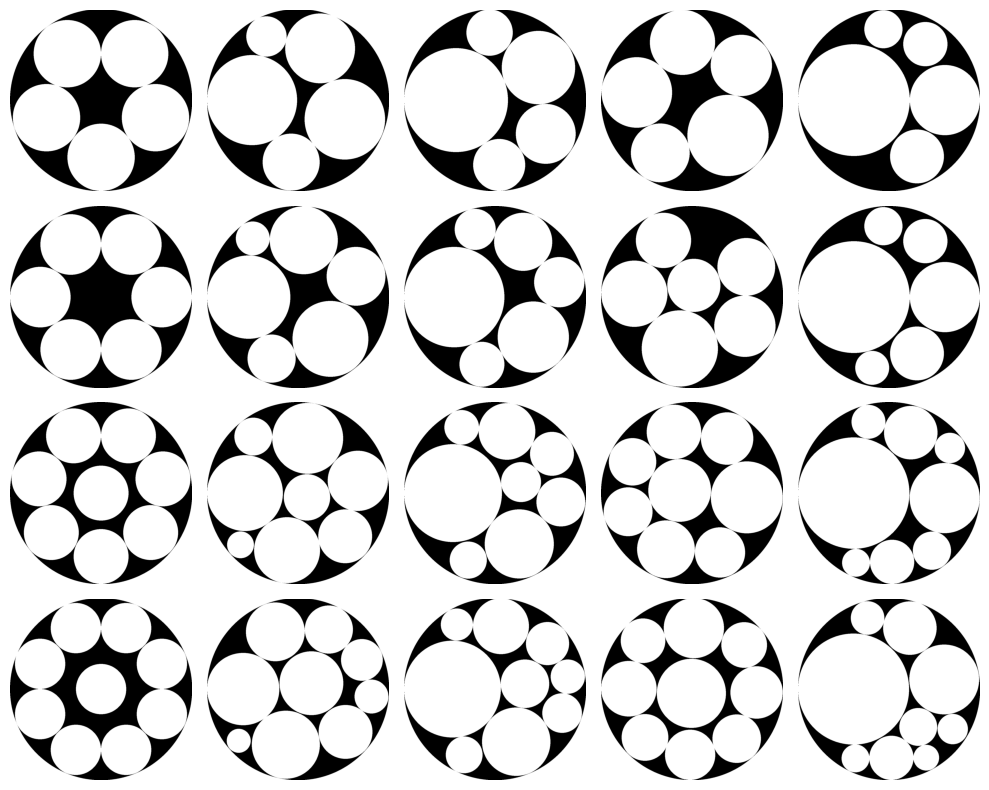

In [14]:
num_circles_list = [5, 6, 8, 9]
num_rows = len(num_circles_list)
num_cols = len(packing_types)
card_size = 1024

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 8))

for row, num_circles in enumerate(num_circles_list):
    for col, packing_type in enumerate(packing_types.keys()):
        image_array = visualize_packing(packing_type, num_circles, card_size, filled=True, return_pil=False)

        # Make the image fully opaque (i.e., turn transparent background black)
        image_array[..., 3] = 255

        # Separate color channels and alpha channel
        color_channels = image_array[..., :3]
        alpha_channel = image_array[..., 3]

        # Invert color channels
        inverted_color_channels = 255 - color_channels

        # Combine inverted color channels with alpha channel
        image_array = np.concatenate((inverted_color_channels, alpha_channel[..., np.newaxis]), axis=2)
        
        axes[row, col].imshow(image_array)
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()


<a id='dobble-deck-load-emoji'></a>

### 2.5 Load emoji from directory
To create our *Dobble* cards, we first need to load the emojis from the `emojis` directory. As mentioned before, the emojis used in this project are taken from [OpenMoji](https://openmoji.org) and are free to use under the [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/) license, which is compatible with the [GNU General Public License v3](https://www.gnu.org/licenses/gpl-3.0.en.html).

In [15]:
def load_emoji(emoji_set, emoji_name, outline_only=False):
    """
    Load an emoji from the specified set of emojis.

    Args:
        emoji_set (str): The name of the set of emojis (e.g., 'dobble-like').
        emoji_name (str): The name of the emoji.
        outline_only (bool, optional): Whether to load the outline-only version of the emoji. Defaults to False.

    Returns:
        PIL.Image.Image: The loaded emoji image in RGBA mode.

    Raises:
        ValueError: If the specified emoji file is not found or does not have a valid PNG extension.
    """
    # Create the file path pointing to the emoji that we want to load
    if outline_only:
        which_type = 'outline'
    else:
        which_type = 'color'

    filepath = os.path.join('emojis', emoji_set, which_type, emoji_name + '.png')

    # Check if the file exists and if it has the correct extension
    if os.path.isfile(filepath) and filepath.lower().endswith('.png'):
        emoji_image = Image.open(filepath)

        # Convert the image to RGBA mode if it's not already
        if emoji_image.mode != 'RGBA':
            emoji_image = emoji_image.convert('RGBA')

        return emoji_image
    else:
        raise ValueError(f"Failed to load emoji: {filepath} is not a valid PNG file.")


<a id='dobble-deck-place-emoji'></a>

### 2.6 Place emoji on card
The `load_emoji` function returns an emoji as a PIL image in RGBA mode. Once we have such an image loaded into memory, we want to place it on another image (i.e., a *Dobble* card). The next function does just that.

In [16]:
def place_emoji(image, emoji_image, emoji_size, center, rotation_angle=None, return_pil=True):
    """
    Place an emoji on the given image at the specified coordinates with the specified size.

    Args:
        image (PIL.Image.Image): The original image as a PIL Image.
        emoji_image (PIL.Image.Image): The emoji as a PIL Image.
        emoji_size (int): The desired size of the emoji in pixels when placed on the image.
        center (tuple): The center coordinates of the emoji in the form (x, y).
        rotation_angle (float, optional): The rotation angle in degrees. Defaults to None.
        return_pil (bool, optional): Whether to return a PIL Image (True) or a NumPy array (False). Defaults to True.

    Returns:
        PIL.Image.Image or numpy.ndarray: The modified image with the emoji placed on it.

    Raises:
        ValueError: If the rotation_angle is provided but is outside the valid range of [0, 360).
    """
    x_center, y_center = center
    
    # Calculate the top-left coordinates of the emoji based on the center coordinates and size
    x_left = x_center - emoji_size // 2
    y_top = y_center - emoji_size // 2

    # Resize the emoji to the specified size
    emoji_image = emoji_image.resize((emoji_size, emoji_size))

    # Check if a rotation angle was specified and validate it
    if rotation_angle is not None:
        if rotation_angle < 0 or rotation_angle >= 360:
            raise ValueError("Invalid rotation angle: must be in the range [0, 360).")
        
        # Rotate the image if the rotation angle is valid
        emoji_image = emoji_image.rotate(rotation_angle)

    # Paste the emoji onto the original image at the specified coordinates
    image.paste(emoji_image, (x_left, y_top), mask=emoji_image)

    if return_pil:
        return image
    else:
        # Convert the image to a NumPy array
        image_array = np.array(image)
        return image_array


<a id='dobble-deck-single-card'></a>

### 2.7 Create a single *Dobble* card

In [17]:
def create_dobble_card(card_size, packing_type, emoji_set, emoji_list, outline_only=False, return_pil=True):
    """
    Create a Dobble card by placing emojis according to the given parameters.

    Args:
        card_size (int): The size of the card in pixels.
        packing_type (str): The type of circle packing. Must be one of the keys in the 'packing_types' dictionary.
        emoji_set (str): The name of the set of emojis.
        emoji_list (list): The list of names of the emojis to be placed on the card.
        return_pil (bool, optional): Whether to return a PIL Image (True) or a NumPy array (False). Defaults to True.

    Returns:
        PIL.Image.Image or numpy.ndarray: The generated Dobble card.

    Example:
        >>> dobble_card = create_dobble_card(1024, 'ccis', 'dobble-like', ['bison', 'bomb', 'trex', 'twitter', 'spoutingwhale'])
    """
    # Create empty Dobble card
    dobble_card = create_empty_card(card_size)
    num_emojis = len(emoji_list)

    # Read relative coordinates from file
    relative_coordinates = read_coordinates_from_file(num_emojis, packing_type)

    # Read largest radius from file and compute remaining radii
    largest_radius = read_radius_from_file(num_emojis, packing_type)
    relative_radii = compute_radii(largest_radius, num_emojis, packing_type)

    # Place emojis on card
    for count, emoji_name in enumerate(emoji_list):
        emoji_image = load_emoji(emoji_set, emoji_name, outline_only)
        emoji_size = convert_radius_to_image_size_in_pixels(relative_radii[count], card_size)
        center = convert_coords_to_pixels(relative_coordinates[count], card_size)
        rotation_angle = random.randint(0, 359)
        dobble_card = place_emoji(dobble_card, emoji_image, emoji_size, center, rotation_angle)

    # Randomly rotate the image
    # NOTE: Since the part of the image that we care about is the inscribed circle (i.e., Dobble card),
    # we can leave the 'expand' parameter of the Image.rotate method set to its default value of False!
    rotation_angle = random.randint(0, 359)
    dobble_card = dobble_card.rotate(rotation_angle)
    
    if return_pil:
        return dobble_card
    else:
        # Convert the image to a NumPy array
        dobble_card_array = np.array(dobble_card)
        return dobble_card_array


Next, let's visualize a few *Dobble* cards!

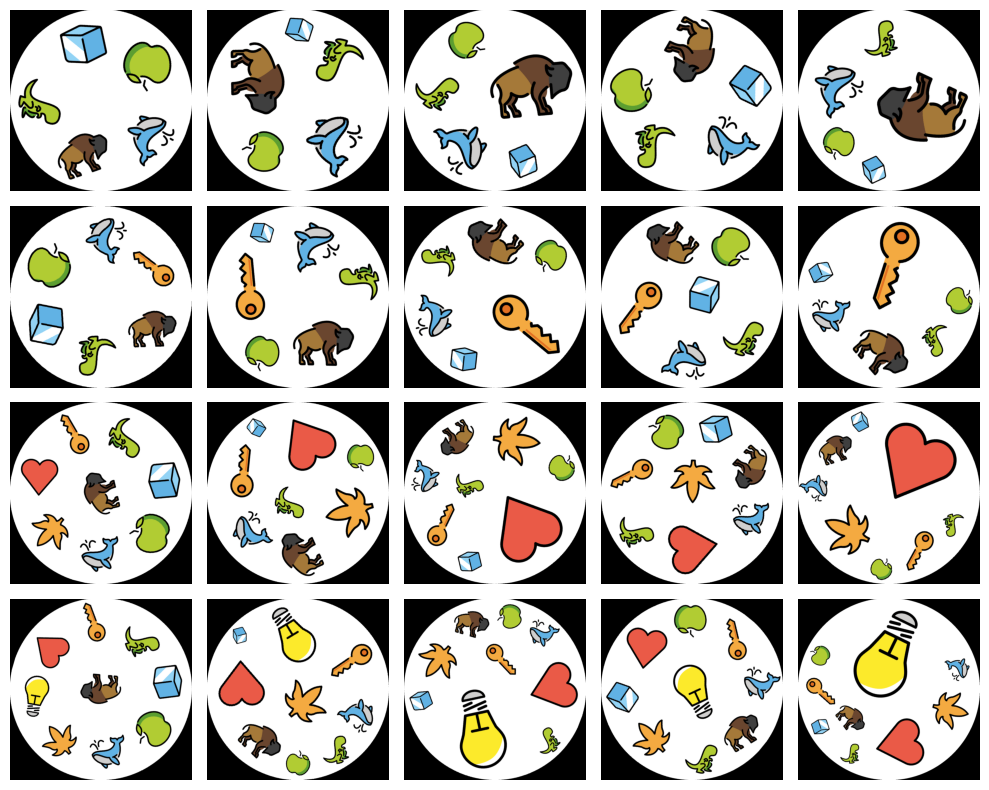

In [18]:
card_size = 1024
emoji_set = 'dobble-like'
emoji_lists = [['ice', 'greenapple', 'trex', 'spoutingwhale', 'bison'],
               ['ice', 'greenapple', 'trex', 'spoutingwhale', 'bison', 'key'],
               ['ice', 'greenapple', 'trex', 'spoutingwhale', 'bison', 'key', 'mapleleaf', 'heart'],
               ['ice', 'greenapple', 'trex', 'spoutingwhale', 'bison', 'key', 'mapleleaf', 'heart', 'lightbulb']]
num_rows = len(emoji_lists)
num_cols = len(packing_types)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 8))

for row, emoji_list in enumerate(emoji_lists):
    for col, packing_type in enumerate(packing_types.keys()):
        # Create dobble card (as NumPy array)
        dobble_card_array = create_dobble_card(card_size, packing_type, emoji_set, emoji_list, return_pil=False)
        
        # Make the image fully opaque (i.e., turn transparent background black)
        dobble_card_array[..., 3] = 255
        
        axes[row, col].imshow(dobble_card_array)
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()


What would it look like if we were to use only the outlines of the emojis? Let's take a look!

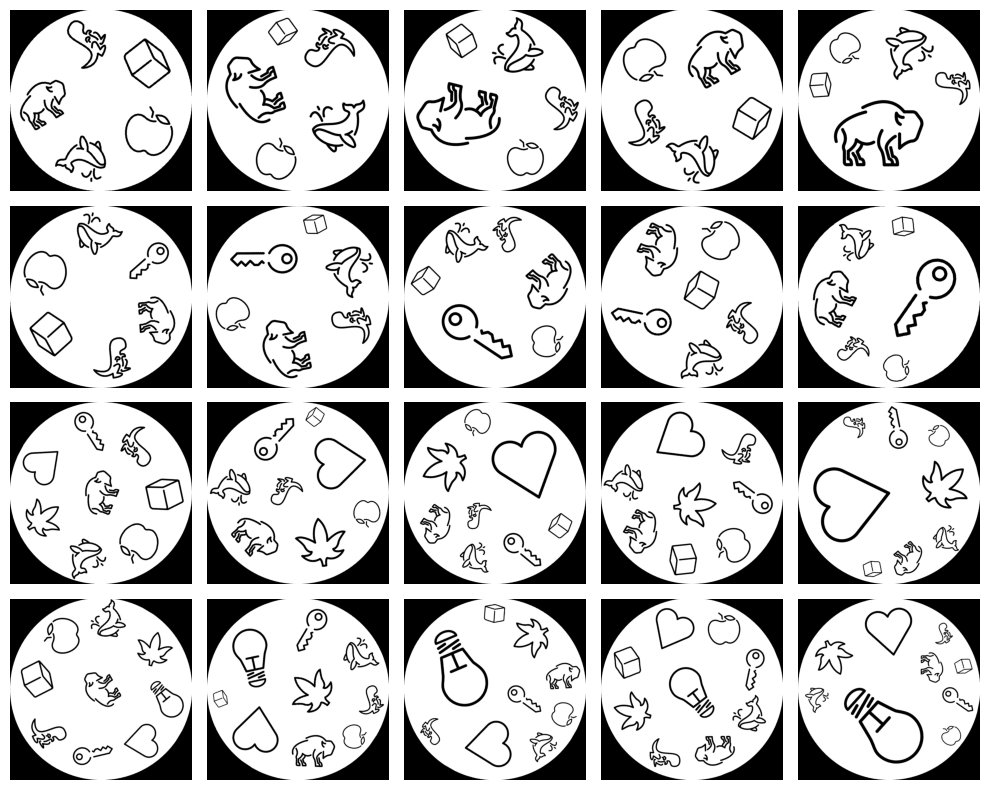

In [19]:
card_size = 1024
emoji_set = 'dobble-like'
emoji_lists = [['ice', 'greenapple', 'trex', 'spoutingwhale', 'bison'],
               ['ice', 'greenapple', 'trex', 'spoutingwhale', 'bison', 'key'],
               ['ice', 'greenapple', 'trex', 'spoutingwhale', 'bison', 'key', 'mapleleaf', 'heart'],
               ['ice', 'greenapple', 'trex', 'spoutingwhale', 'bison', 'key', 'mapleleaf', 'heart', 'lightbulb']]
num_rows = len(emoji_lists)
num_cols = len(packing_types)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 8))

for row, emoji_list in enumerate(emoji_lists):
    for col, packing_type in enumerate(packing_types.keys()):
        # Create dobble card (as NumPy array)
        dobble_card_array = create_dobble_card(card_size, packing_type, emoji_set, emoji_list, outline_only=True, return_pil=False)
        
        # Make the image fully opaque (i.e., turn transparent background black)
        dobble_card_array[..., 3] = 255
        
        axes[row, col].imshow(dobble_card_array)
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()


<a id='dobble-deck-read-emoji-names'></a>

### 2.8 Read in names of all emojis of a given set
<font color = red>**TO-DO:**</font> Add explanation.

In [20]:
def get_emoji_names(emoji_set, outline_only=False):
    """
    Retrieves the names of emojis of the specified set of emojis.

    Args:
        emoji_set (str): The name of the emoji set to use (e.g., 'dobble-like').
        outline_only (bool, optional): Specifies whether to retrieve names of emojis with outline only. Defaults to False.

    Returns:
        list: A list of names of all emojis in the specified set.
    """
    if outline_only:
        directory_path = os.path.join('emojis', emoji_set, 'outline')
    else:
        directory_path = os.path.join('emojis', emoji_set, 'color')
    
    emoji_names = []
    for file in os.listdir(directory_path):
        if file.endswith('.png'):
            # Extract the base name without extension (i.e., without '.png')
            emoji_name = os.path.splitext(file)[0]
            emoji_names.append(emoji_name)
    emoji_names.sort()
    return emoji_names


<a id='dobble-deck-full-decks'></a>

### 2.9 Create a full *Dobble* deck
Finally, we put everything together to create a full *Dobble* deck. Let's outline the major steps we need to take to end up with a full deck of *Dobble* cards:

- These are the parameters we need to specify:
    * `emoji_set` **Which set of emojis** do we want to use to create the *Dobble* deck?
    * `num_emojis_per_card` **How many emojis** do we want **on each card**? Remember that this number needs to be equal to $p^k + 1$ with $p$ being prime (i.e., an integer that immediately follows a prime power)
    * `deck_name` What do we want to call our newly created *Dobble* deck? This will also serve as the **name of the subdirectory** of the `dobble-decks` directory, where we will store the images.
    * `outline_only` Do we want to use the **colored versions** of the emojis **or** just their **outlines**?
    * `packing_type` Do we want to use one **type of circle packing** for all cards or do we want to choose the packing type randomly for each card to have greater variability between cards?
- To create our *Dobble* deck, we have to perform the following steps in order:
    1. Compute the incidence matrix of the finite projective plane of the appropriate order (Remember: The order of the projective plane is one less than the number of symbols on each card!)

<font color = red>**TO-DO:**</font> Finish instructions!

In [21]:
def create_dobble_deck(emoji_set, num_emojis_per_card, card_size, deck_name, outline_only=False, packing_type=None):
    """
    Create a full set of Dobble cards (i.e., generate and save image files).

    Args:
        emoji_set (str): The name of the emoji set to use.
        num_emojis_per_card (int): The number of emojis to place on each card.
        card_size (int): The size of each card in pixels.
        deck_name (str): The name of the Dobble deck.
        outline_only (bool, optional): Whether to generate cards with outline-only emojis. Defaults to False.
        packing_type (str, optional): The type of packing to use for placing emojis on the cards.
            If not provided, a packing type is randomly chosen for each card. Defaults to None.

    Returns:
        str: The file path to the generated CSV file.
    """
    # Create a directory to store the Dobble cards
    deck_directory = os.path.join('dobble-decks', deck_name)
    if os.path.exists(deck_directory):
        csv_file =  os.path.join(deck_directory, 'info.csv')
        return csv_file
    else:
        os.makedirs(deck_directory)
    
    # Compute order of finite projective plane as well as its incidence matrix
    order = num_emojis_per_card - 1
    incidence_matrix = compute_incidence_matrix(order)

    # The number of cards in a Dobble deck is given by n^2 + n + 1, with n + 1 = # symbols on each card
    # NOTE: Remember that there are as many distinct symbols in a deck of Dobble cards as there are cards
    num_cards = order ** 2 + order + 1

    # Read in the names of all emojis in the specified subdirectory ('emoji_set') of the 'emojis' directory
    emoji_names = get_emoji_names(emoji_set)

    # Check if there are enough emojis in the specified subdirectory
    num_emojis_available = len(emoji_names)
    if num_emojis_available < num_cards:
        raise ValueError("Not enough emojis in the specified set of emojis to create the Dobble deck.")
    elif num_emojis_available > num_cards:
        # If there are more emojis than we need, we randomly choose a subset of the appropriate size
        emoji_names = random.sample(emoji_names, num_cards)

    # If no 'packing_type' was provided initially, choose one randomly each time from the 'packing_types' dictionary
    if packing_type is None:
        choose_randomly = True
    else:
        choose_randomly = False

    # Create CSV file to store information
    csv_file = os.path.join(deck_directory, 'info.csv')
    with open(csv_file, 'w', newline='') as f:
        writer = csv.writer(f, delimiter=';')
        writer.writerow(['CardNr'] + ['FilePath'] + ['PackingType'] + ['Emoji' + str(i+1) for i in range(num_emojis_per_card)])
    
    # Create Dobble cards one-by-one using the incidence matrix to decide which emojis to put on each card
    # NOTE: len(a) is equivalent to np.shape(a)[0] for N-D arrays with N>=1.
    for card in range(len(incidence_matrix)):
        # Find the emojis that are to be placed on the card
        which_emojis = np.where(incidence_matrix[card])[0]
        emoji_list = [emoji_names[idx] for idx in which_emojis]
        random.shuffle(emoji_list)
        
        # If no 'packing_type' was provided initially, choose one randomly from the 'packing_types' dictionary
        if choose_randomly:
            packing_type = random.choice(list(packing_types.keys()))
        
        # Create Dobble card and save in directory
        dobble_card = create_dobble_card(card_size, packing_type, emoji_set, emoji_list, outline_only)
        file_name = f"{deck_name}_{card + 1:03d}.png"
        file_path = os.path.join('dobble-decks', deck_name, file_name)
        dobble_card.save(file_path)

        # Write card information to the CSV file
        with open(csv_file, 'a', newline='') as f:
            writer = csv.writer(f, delimiter=';')
            writer.writerow([f"{(card + 1):03d}"] + [file_path] + [packing_type] + emoji_list)

    return csv_file


<font color=red>**TO-DO:**</font> Add text!

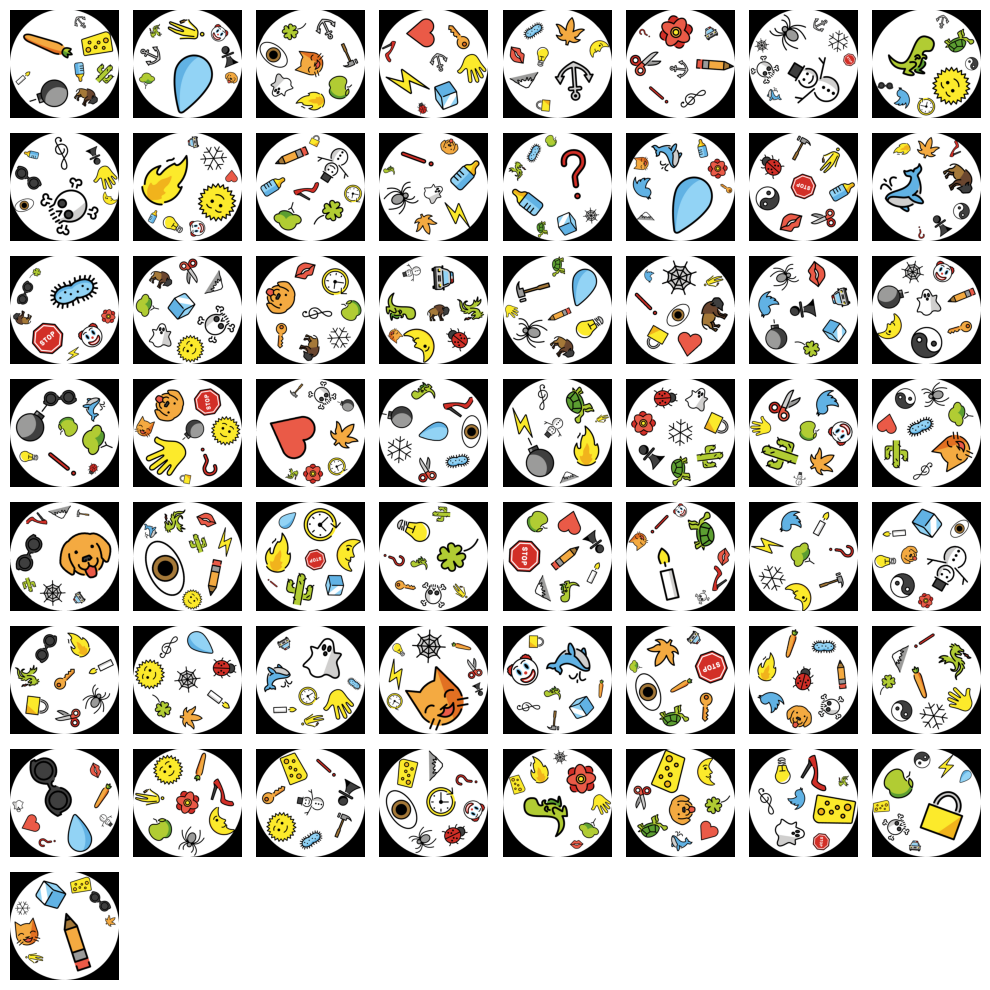

In [22]:
# Create our first full deck of Dobble
emoji_set = 'dobble-like'
num_emojis_per_card = 8
card_size = 1024
deck_name = 'dobble-like-8-color-1024'
csv_file = create_dobble_deck(emoji_set, num_emojis_per_card, card_size, deck_name)

# Create a list to store the image paths
image_paths = []

# Extract the file paths from the CSV file
with open(csv_file, 'r') as f:
    reader = csv.reader(f, delimiter=';')
    next(reader)  # Skip the header
    for row in reader:
        image_paths.append(row[1])  # File paths are stored in the second column

# Visualize all 7^2 + 7 + 1 = 57 cards in an 8x8 layout
fig, axes = plt.subplots(8, 8, figsize=(10, 10))

for count, ax in enumerate(axes.flat):
    # Check if there are still images remaining
    if count < len(image_paths):
        image = Image.open(image_paths[count])
        image_array = np.array(image)
        
        # Make the image fully opaque (i.e., turn transparent background black)
        image_array[..., 3] = 255
        ax.imshow(image_array)
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()


<a id='dobble-deck-combinations'></a>

### 2.10 All possible combinations of cards in a *Dobble* deck
<font color=red>**TO-DO:**</font> Add text!

In [23]:
def analyze_dobble_deck(csv_file):
    """
    Analyze a Dobble deck generated by the 'create_dobble_deck' function.

    Args:
        csv_file (str): The file path to the CSV file generated by 'create_dobble_deck'.

    Returns:
        list: A list of dictionaries, where each dictionary represents a pair of cards.
            Each dictionary contains the card numbers, file paths, and common emoji.
    """
    combinations_list = []
    
    with open(csv_file, 'r') as f:
        reader = csv.reader(f, delimiter=';')
        next(reader)  # Skip the header row
    
        # Read the card information from the CSV file into a list of lists (inner lists correspond to rows)
        card_info = list(reader)
    
        # Generate all combinations of pairs of cards (ignoring the order of cards)
        card_pairs = combinations(card_info, 2)
    
        # Iterate over each pair of cards
        for pair in card_pairs:
            card1_num = int(pair[0][0])  # Extract number of the first card
            card2_num = int(pair[1][0])  # Extract number of the second card
            card1_path = pair[0][1]      # Extract file path of the first card
            card2_path = pair[1][1]      # Extract file path of the second card
            emojis1 = pair[0][3:]        # Extract emojis that are placed on the first card
            emojis2 = pair[1][3:]        # Extract emojis that are placed on the second card
    
            # Find the common emoji between the two cards
            common_emoji = (set(emojis1) & set(emojis2)).pop()
    
            # Create a dictionary to store all of the information
            pair_info = {
                'card1': card1_num,
                'card2': card2_num,
                'card1_path': card1_path,
                'card2_path': card2_path,
                'common_emoji': common_emoji
            }
    
            combinations_list.append(pair_info)
            
    random.shuffle(combinations_list)
    return combinations_list


<a id='neural-network'></a>

## Part 3: A deep neural network to play *Dobble*
<font color=red>**TO-DO:**</font> Add text!

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<a id='neural-network-dataset'></a>

### 3.1 *DobbleDeck*
<font color=red>**TO-DO:**</font> Add text!

In [25]:
class DobbleDeck(torch.utils.data.Dataset):
    def __init__(self, emoji_set, num_emojis_per_card, card_size, deck_name,
                 outline_only=False, packing_type=None, transform=None):
        """
        Args:
            emoji_set (str): The name of the emoji set to use.
            num_emojis_per_card (int): The number of emojis to place on each card.
            card_size (int): The size of each card in pixels.
            deck_name (str): The name of the Dobble deck.
            outline_only (bool, optional): Whether to generate cards with outline-only emojis. Defaults to False.
            packing_type (str, optional): The type of packing to use for placing emojis on the cards.
                If not provided, a packing type is randomly chosen for each card. Defaults to None.
            transform (callable, optional): Optional transform to be applied on the card images. Defaults to None.
    
        Attributes:
            combinations (list): A list of dictionaries, where each dictionary represents a pair of cards.
                Each dictionary contains the card numbers, file paths, and common emoji.
            transform (callable or None): Optional transform to be applied on the card images.
        """
        csv_file = create_dobble_deck(emoji_set, num_emojis_per_card, card_size, deck_name, outline_only, packing_type)
        self.combinations = analyze_dobble_deck(csv_file)
        self.transform = transform
    
    def __len__(self):
        return len(self.combinations)

    def __getitem__(self, idx):
        card1_path = self.combinations[idx]['card1_path']
        card2_path = self.combinations[idx]['card2_path']
        card1 = Image.open(card1_path).convert('RGB')
        card2 = Image.open(card2_path).convert('RGB')

        if self.transform:
            card1 = self.transform(card1)
            card2 = self.transform(card2)
        
        common_emoji = self.combinations[idx]['common_emoji']

        return card1, card2, common_emoji


<a id='neural-network-training-transforms'></a>

#### 3.1.1 Transforms
<font color=red>**TO-DO:**</font> Implement meaningful transform!

In [26]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])


<font color=red>**TO-DO:**</font> Add text!

In [27]:
emoji_set = 'dobble-like'
num_emojis_per_card = 8
card_size = 224
deck_name = 'dobble-like-8-color-224'
classic_dobble_set = DobbleDeck(emoji_set, num_emojis_per_card, card_size, deck_name)


<a id='neural-network-training-testing'></a>

#### 3.1.2 Training & testing sets
Next, we split our dataset into training and testing sets.

In [28]:
# Define the desired split ratio (in this case, 80% training and 20% testing)
train_ratio = 0.8

# Calculate the number of samples for training and testing based on the specified 'train_ratio'
train_size = int(train_ratio * len(classic_dobble_set))
test_size = len(classic_dobble_set) - train_size

# Randomly split the dataset
train_dataset, test_dataset = torch.utils.data.random_split(classic_dobble_set, [train_size, test_size])


<a id='neural-network-dataloaders'></a>

#### 3.1.3 DataLoaders
Now that we have both datasets (i.e., training and testing), we prepare the DataLoaders accordingly.

In [29]:
batch_size = 8
num_workers = 2

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=num_workers, pin_memory=True, sampler=None
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False,
    num_workers=num_workers, pin_memory=True, sampler=None
)


<a id='neural-network-dobble-net'></a>

### 3.2 *DobbleNet*
<font color=red>**TO-DO:**</font> Add text!

In [65]:
class DobbleNet(nn.Module):
    def __init__(self, num_emojis_per_card: int) -> None:
        """
        Args:
            num_emojis_per_card (int): The number of emojis on each card (determines number of distinct emojis [i.e., classes]).
        """
        super().__init__()

        order = num_emojis_per_card - 1
        num_classes = order**2 + order + 1

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            # NOTE: Multplication by 2 is necessary because we will pass the concatenated features of two tensors
            # -- that were individually passed through 'self.features' -- to the classifier
            nn.Linear(2 * 7 * 7 * 128, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        y = self.features(y)
        # Concatenate x and y along the feature dimension and pass through classifier
        comb_features = torch.cat([x, y], dim=1)
        output = self.classifier(comb_features)
        
        return output


<font color=red>**TO-DO:**</font> Add text!

In [59]:
# We instantiate an instance of DobbleNet and move the model to the GPU, if available
# NOTE: 'num_emojis_per_card' is still defined from when we generated our dataset
model = DobbleNet(num_emojis_per_card=num_emojis_per_card)
model = model.to(device)
print(model)

DobbleNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(25

<a id='neural-network-training-testing-routines'></a>

### 3.3 Training & testing routines

<a id='neural-network-loss'></a>

#### 3.3.1 Loss function
Since our ground-truth is a finite set of categories (i.e., the distinct emojis in a deck of *Dobble* cards), we will use `nn.CrossEntropyLoss` as our loss function.

In [32]:
# We define our loss function and move it to the GPU, if available
criterion = nn.CrossEntropyLoss().to(device)

<a id='neural-network-optimizer'></a>

#### 3.3.2 Optimizer

In [33]:
# TODO: Define optimizer!

<a id='neural-network-utility-functions'></a>

### 3.4 Utility functions

<a id='neural-network-accuracy'></a>

#### 3.4.1 `accuracy`

In [66]:
def accuracy(output, target, topk=(1,)):
    """
    Calculates the accuracy of a model's output predictions.

    Args:
        output (torch.Tensor): Model's output tensor.
        target (torch.Tensor): Target tensor containing the ground truth labels.
        topk (tuple): Tuple of integers representing the top-k values to consider for accuracy calculation.
            Defaults to (1,).

    Returns:
        list: A list of torch.Tensor objects representing accuracy values for each top-k value specified.

    Note:
        - The accuracy is calculated by comparing the model's predicted labels (output) with the ground truth labels (target).
        - The top-k accuracy considers whether the correct label is among the top-k predicted labels.
        - The function assumes that the input tensors (output and target) have compatible shapes.

    Example:
        >>> output = torch.tensor([[0.2, 0.3, 0.5], [0.7, 0.1, 0.2]])
        >>> target = torch.tensor([1, 1])
        >>> accuracy(output, target, topk=(1, 2, 3))
        [tensor([0.]), tensor([50.]), tensor([100.])]
    """
    with torch.no_grad():
        maxk = max(topk)            # max 'topk' value
        batch_size = target.size(0) # number of labels (= number of samples in the batch)

        # Compute indices of top k values for each prediction
        _, pred = output.topk(maxk, 1, largest=True, sorted=True)
        pred = pred.t()

        # Check whether predictions match target (i.e., ground truth labels)
        # NOTE: The '-1' in target.view(1, -1) implies that the size of this dimension is inferred from other dimensions
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res
